In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.autograd import Variable
from uuid import uuid4
import syft as sy
from matplotlib import pyplot as plt

In [2]:
class Distribute_MNIST:
    """
  This class distribute each image among different workers
  It returns a dictionary with key as data owner's id and 
  value as a pointer to the list of data batches at owner's 
  location.
  
  example:-  
  >>> from distribute_data import Distribute_MNIST
  >>> obj = Distribute_MNIST(data_owners= (alice, bob, claire), data_loader= torch.utils.data.DataLoader(trainset)) 
  >>> obj.data_pointer[1]['alice'].shape, obj.data_pointer[1]['bob'].shape, obj.data_pointer[1]['claire'].shape
   (torch.Size([64, 1, 9, 28]),
    torch.Size([64, 1, 9, 28]),
    torch.Size([64, 1, 10, 28]))
  """

    def __init__(self, data_owners, data_loader):

        """
         Args:
          data_owners: tuple of data owners
          data_loader: torch.utils.data.DataLoader for MNIST 

        """

        self.data_owners = data_owners
        self.data_loader = data_loader
        self.no_of_owner = len(data_owners)

        self.data_pointer = []
        """
        self.data_pointer:  list of dictionaries where 
        (key, value) = (id of the data holder, a pointer to the list of batches at that data holder).
        example:
        self.data_pointer  = [
                                {"alice": pointer_to_alice_batch1, "bob": pointer_to_bob_batch1},
                                {"alice": pointer_to_alice_batch2, "bob": pointer_to_bob_batch2},
                                ...
                             ]
        """

        self.labels = []

        # iterate over each batch of dataloader for, 1) spliting image 2) sending to VirtualWorker
        for images, labels in self.data_loader:

            curr_data_dict = {}

            # calculate width and height according to the no. of workers for UNIFORM distribution
            height = images.shape[-1]//self.no_of_owner

            self.labels.append(labels)

            # iterate over each worker for distribution of current batch of the self.data_loader
            for i, owner in enumerate(self.data_owners[:-1]):

                # split the image and send it to VirtualWorker (which is supposed to be a dataowner or client)
                image_part_ptr = images[:, :, :, height * i : height * (i + 1)].send(
                    owner
                )

                curr_data_dict[owner.id] = image_part_ptr

            # Repeat same for the remaining part of the image
            last_owner = self.data_owners[-1]
            last_part_ptr = images[:, :, :, height * (i + 1) :].send(last_owner)

            curr_data_dict[last_owner.id] = last_part_ptr

            self.data_pointer.append(curr_data_dict)
            
    def __iter__(self):
        
        for data_ptr, label in zip(self.data_pointer[:-1], self.labels[:-1]):
            yield (data_ptr, label)
            
    def __len__(self):
        
        return len(self.data_loader)-1
            


In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
hook = sy.TorchHook(torch)


In [4]:
torch.cuda.is_available()

True

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10 is a dataset of natural images consisting of 50k training images and 10k test
# Every image is labelled with one of the following class
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
from FLDataset import CustomCIFARDataset
custom_trainset = CustomCIFARDataset(root='./data', train=True,
                                        download=True, transform=transform, client_num=10)

Files already downloaded and verified


In [7]:
# Assign custom dataset to each client 
client_trainloader = []
for i in range(10):
    custoom_data = CustomCIFARDataset(root='./data', train=True,
                                        download=True, transform=transform, client_num=i)
    client_trainloader.append(
    torch.utils.data.DataLoader(custoom_data, batch_size=128, shuffle=True, num_workers=2)
    )
    
    

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


image[0].shape:  torch.Size([3, 32, 2])


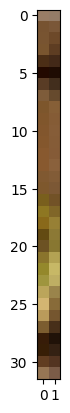

In [10]:
# image = custom_trainset[0]
print("image[0].shape: ", custom_trainset[0][0].shape)
imshow(torchvision.utils.make_grid(custom_trainset[0][0]))

In [ ]:
image = custom_trainset[0]
print("image[0].shape: ", image[0].shape)
# image[0][:, :, height * i : height * (i + 1)].shape
height = image[0].shape[-1]//10
i = 1
newImg = image[0][:, :, height * i : height * (i + 1)]
newImg[0].shape

In [ ]:
newImg.shape
imshow(torchvision.utils.make_grid(newImg))

torch.Size([3, 32, 32])


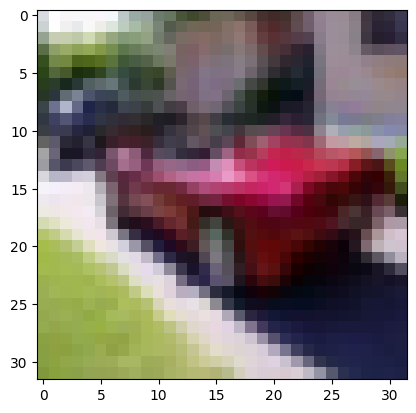

In [9]:
def imshow(img):
    img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()   # convert from tensor
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()
for item in trainloader:
    print(item[0][0].shape)
    imshow(torchvision.utils.make_grid(item[0][0]))
    break

In [ ]:
newImg.shape

In [11]:
# Explain nn.Module and explain the forward and backward pass
class ResNet18Client(nn.Module):
    """docstring for ResNet"""

    # Explain initialize (listing the neural network architecture and other related parameters)
    def __init__(self, config):
        super(ResNet18Client, self).__init__()
        # Explain this line
        self.cut_layer = config["cut_layer"]

        # Explain this line
        self.model = models.resnet18(pretrained=False)

        self.model = nn.ModuleList(self.model.children())
        self.model = nn.Sequential(*self.model)

    # Explain forward (actually used during the execution of the neural network at runtime)
    def forward(self, x):
        for i, l in enumerate(self.model):
            if i > self.cut_layer:
                break
            x = l(x)
        return x

In [12]:
class ResNet18Server(nn.Module):
    """docstring for ResNet"""

    def __init__(self, config):
        super(ResNet18Server, self).__init__()
        self.logits = config["logits"]
        self.cut_layer = config["cut_layer"]

        self.model = models.resnet18(pretrained=False)
        num_ftrs = self.model.fc.in_features
        # Explain this part
        self.model.fc = nn.Sequential(nn.Flatten(),
                                      nn.Linear(num_ftrs, self.logits))

        self.model = nn.ModuleList(self.model.children())
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        for i, l in enumerate(self.model):
            # Explain this part
            if i <= self.cut_layer:
                continue
            x = l(x)
        return nn.functional.softmax(x, dim=1)

### Initialize the models

In [27]:
config = {"cut_layer": 6, "logits": 10}
client_model = ResNet18Client(config).to(device)
server_model = ResNet18Server(config).to(device)

### Set up the optimizer

In [28]:
criterion = nn.CrossEntropyLoss()
client_optimizer = optim.SGD(client_model.parameters(), lr=0.01, momentum=0.9)
server_optimizer = optim.SGD(server_model.parameters(), lr=0.01, momentum=0.9)

### Set up the training pipeline

### Add the training diagram and draw forward pass and backward pass

In [29]:
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        client_optimizer.zero_grad()
        server_optimizer.zero_grad()
        
        # Client part
        activations = client_model(inputs)
        server_inputs = activations.detach().clone()
        
        # Simulation of server part is happening in this portion
        # Server part
        server_inputs = Variable(server_inputs, requires_grad=True)
        outputs = server_model(server_inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # server optimization
        server_optimizer.step()
        
        # Simulation of Client Happening in this portion
        # Client optimization
        activations.backward(server_inputs.grad)
        client_optimizer.step()

        running_loss += loss.item()
        
        if i % 200 == 199:
            print('[{}, {}] loss: {}'.format(epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0


[1, 200] loss: 2.1386938840150833
[2, 200] loss: 1.9755915969610214
[3, 200] loss: 1.8985161328315734
[4, 200] loss: 1.85710799574852
[5, 200] loss: 1.830213206410408


In [22]:
# You can save the model for analyzing it in the future
import os
current_save_dir = os.getcwd() + '/Experiments/split-learning/saved_models'
os.mkdir(current_save_dir)


'/home/aminmoradi/jupyter/openml-fed'

In [23]:
client_model_path = current_save_dir + "/trained_client_model.pt"
server_model_path = current_save_dir + "/trained_server_model.pt"
torch.save(client_model.state_dict(), client_model_path)
torch.save(server_model.state_dict(), server_model_path)

In [24]:
# Mention that accuracy is low because of low number of epochs
total, correct = 0, 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = server_model(client_model(inputs))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(correct/total)

0.6132


In [25]:
clients_hooks = []
total_client_num = 10
hook = sy.TorchHook(torch)
for i in range(total_client_num):
    clients_hooks.append(sy.VirtualWorker(hook, id="client_" + str(i)))



# Initialize multiple clients
client_model_list = []
for client_num in range(total_client_num):
        model = ResNet18Client(config).to(device)
        model.send(clients_hooks[client_num])
        client_model_list.append(model)

# Initialize multiple optimizers
client_optimizer_list = [optim.SGD(client_model_list[client_num].parameters(), lr=0.01, momentum=0.9) for client_num in range(total_client_num)]
server = ResNet18Server(config).to(device)
server_optimizer = optim.SGD(server.parameters(), lr=0.01, momentum=0.9)

In [26]:

distributed_trainloader = Distribute_MNIST(data_owners=tuple(clients_hooks), data_loader=trainloader)

In [38]:
# Assign custom dataset to each client 
total_client_num = 10
client_trainloader = []
for i in range(total_client_num):
    custoom_data = CustomCIFARDataset(root='./data', train=True,
                                        download=True, transform=transform, client_num=i)
    client_trainloader.append(
    torch.utils.data.DataLoader(custoom_data, batch_size=128, shuffle=True, num_workers=2)
    )
    

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [39]:

# Initialize multiple clients
client_model_list = [ResNet18Client(config).to(device) for client_num in range(total_client_num)]
# Initialize multiple optimizers
client_optimizer_list = [optim.SGD(client_model_list[client_num].parameters(), lr=0.01, momentum=0.9) for client_num in range(total_client_num)]
server = ResNet18Server(config).to(device)
server_optimizer = optim.SGD(server.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [40]:
num_epochs = 50 // total_client_num
for epoch in range(200):
    
    # Iterate over multiple clients

      # All clients have their own data source and we are using a single trainloader here for illustration of the simulated setup
#         for i, data in enumerate(client_trainloader[client_num], 0):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        activations = []
        client_optimizers = []
        for client_num in range(total_client_num):
#             print("Current active client is {}".format(client_num))
            client = client_model_list[client_num]
            client_optimizer = client_optimizer_list[client_num]
            client.train()
            client_optimizer.zero_grad()
            activation = client(inputs)
            # Logic to load the weights from the previous client
            activations.append(activation) 
            client_optimizers.append(client_optimizer)
            
        running_loss = 0.0
        total_samples = 0
        
        server_optimizer.zero_grad()

        # Client part

        server_inputs = torch.mean(torch.stack(activations), dim=0).detach().clone()

        #Server part
        server_inputs = Variable(server_inputs, requires_grad=True)
        outputs = server(server_inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        server_optimizer.step()

        running_loss += loss.item()
        total_samples += labels.shape[0]
        for activation, client_optimizer in zip(activations, client_optimizers):
            # Client part
            activation.backward(server_inputs.grad)
            client_optimizer.step()

        if i % 50 == 1:
            print('Epoch: {}, Iteration: {}, Loss: {:.4f}'.format(epoch, i, loss))


Epoch: 0, Iteration: 1, Loss: 2.2991
Epoch: 0, Iteration: 51, Loss: 2.1840
Epoch: 0, Iteration: 101, Loss: 2.0722
Epoch: 0, Iteration: 151, Loss: 2.1180
Epoch: 0, Iteration: 201, Loss: 2.0360
Epoch: 0, Iteration: 251, Loss: 2.0200
Epoch: 0, Iteration: 301, Loss: 1.9704
Epoch: 0, Iteration: 351, Loss: 1.9836
Epoch: 1, Iteration: 1, Loss: 1.9568
Epoch: 1, Iteration: 51, Loss: 2.0210
Epoch: 1, Iteration: 101, Loss: 1.9246
Epoch: 1, Iteration: 151, Loss: 1.9311
Epoch: 1, Iteration: 201, Loss: 1.9956
Epoch: 1, Iteration: 251, Loss: 1.9582
Epoch: 1, Iteration: 301, Loss: 1.9665
Epoch: 1, Iteration: 351, Loss: 1.8856
Epoch: 2, Iteration: 1, Loss: 1.9003
Epoch: 2, Iteration: 51, Loss: 1.9121
Epoch: 2, Iteration: 101, Loss: 1.8501
Epoch: 2, Iteration: 151, Loss: 1.8220
Epoch: 2, Iteration: 201, Loss: 1.9426
Epoch: 2, Iteration: 251, Loss: 1.8922
Epoch: 2, Iteration: 301, Loss: 1.8500
Epoch: 2, Iteration: 351, Loss: 1.8729
Epoch: 3, Iteration: 1, Loss: 1.8921
Epoch: 3, Iteration: 51, Loss: 1.887

In [30]:
torch.mean(torch.stack(activations), dim=0).shape

torch.Size([128, 64, 8, 8])

In [ ]:
num_epochs = 50 // total_client_num
for epoch in range(num_epochs):
    
    # Iterate over multiple clients
    for client_num in range(total_client_num):
        print("Current active client is {}".format(client_num))
        client = client_model_list[client_num]
        client_optimizer = client_optimizer_list[client_num]
        # Logic to load the weights from the previous client
        print('client_num', client_num)
        if client_num == 0:
            if epoch != 0:
                prev_client = total_client_num - 1
                prev_client_weights = client_model_list[prev_client].state_dict()
                client.load_state_dict(prev_client_weights)
                print("Loaded client {}'s weight successfully".format(prev_client))
        else:
            prev_client = client_num - 1
            prev_client_weights = client_model_list[prev_client].state_dict()
            client.load_state_dict(prev_client_weights)
            print("Loaded client {}'s weight successfully".format(prev_client))

        client.train()
        running_loss = 0.0
        total_samples = 0
      # All clients have their own data source and we are using a single trainloader here for illustration of the simulated setup
#         for i, data in enumerate(client_trainloader[client_num], 0):
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            client_optimizer.zero_grad()
            server_optimizer.zero_grad()
            
            # Client part
            activations = client(inputs)
            server_inputs = activations.detach().clone()
            
            #Server part
            server_inputs = Variable(server_inputs, requires_grad=True)
            outputs = server(server_inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            server_optimizer.step()
            
            running_loss += loss.item()
            total_samples += labels.shape[0]
            # Client part
            activations.backward(server_inputs.grad)
            client_optimizer.step()
          
            if i % 50 == 1:
                print('Client: {} Epoch: {}, Iteration: {}, Loss: {:.4f}'.format(client_num, epoch, i, running_loss/(i+1)))


In [ ]:
import os 
os.mkdir('saved_models_splitNN')
client_model_path = "./saved_models_splitNN/trained_client_model_499_epoch.pt"
server_model_path = "./saved_models_splitNN/trained_server_model_499_epoch.pt"
torch.save(client.state_dict(), client_model_path)
torch.save(server.state_dict(), server_model_path)

# Future Directions

1. How to make the round robin protocol asynchronous?
2. Different data distribution across clients?
3. Different topologies of client models, multiple servers, etc.